### **Connect to Google Drive to access dataset files**

---


Use Google Drive because of the size of the dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Import Libraries**

---


import all of the libraries we'll need for the implementation


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm




In [3]:
# import warnings

# warnings.filterwarnings("ignore")
# import logging

# logging.disable(logging.CRITICAL)

### **Read data and lableing**

---



In [6]:
import pandas as pd

# create a list of subject ids
subject_ids = ['s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13', 's14', 's15', 's16', 's17', 's18', 's19']

# create an empty list to store the dataframes
dfs = []

# loop through each subject id and read the corresponding CSV file
for subject_id in subject_ids:
    filename = f"/content/drive/MyDrive/spars9x_{subject_id}.csv"
    df = pd.read_csv(filename)

    # rename columns and replace activity labels
    df.columns = ['Acc_x','Acc_y','Acc_z','Mag_x','Mag_y','Mag_z',
                  'Gyro_x','Gyro_y','Gyro_z','HR','Shoulder','activity_label']
    df['activity_label'] = df['activity_label'].replace(
        [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0],
        ['ADL','Exteranl_Rot','Exteranl_Rot_in_90',"internal_Rot",
         'Extension','Abduction','Biceps_Muscle','Cross_chest',
         'Active_Flexion','Shoulder_Girdle','Triceps_Pull'])

    # append the dataframe to the list
    dfs.append(df)

# concatenate all dataframes into a single dataframe
df = pd.concat(dfs, ignore_index=True)

In [7]:
df

,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,Gyro_x,Gyro_y,Gyro_z,HR,Shoulder,activity_label
0,9.539270,0.624222,0.555485,-35.673008,0.534205,-9.648009,-0.013076,0.020098,-0.012007,107.000000,1.0,Active_Flexion
1,9.527744,0.620525,0.594898,-35.360845,0.471163,-10.234085,-0.000907,0.024422,-0.004026,107.000000,1.0,Active_Flexion
2,9.635094,0.663237,0.548007,-36.025820,-0.085435,-9.679993,0.014177,0.018552,-0.000487,107.000000,1.0,Active_Flexion
3,9.807285,0.681485,0.655692,-35.103742,0.146556,-9.226748,0.015844,0.019085,0.008125,107.000000,1.0,Active_Flexion
4,9.679459,0.663224,0.657975,-34.408069,-0.272274,-8.868715,0.009901,0.019155,0.021907,107.000000,1.0,Active_Flexion
...,...,...,...,...,...,...,...,...,...,...,...,...
22884135,0.914511,-9.480881,2.412483,-3.633922,37.471901,-14.467147,-0.011241,0.022864,-0.023076,66.383046,0.0,ADL
22884136,0.911665,-9.488169,2.418764,-4.269858,38.285229,-14.686707,-0.018702,0.020439,-0.019538,66.403608,0.0,ADL
22884137,0.916438,-9.487555,2.419150,-4.321521,37.675535,-14.923272,-0.018669,0.018834,-0.017365,66.424170,0.0,ADL
22884138,0.918741,-9.486500,2.398030,-4.962599,38.417707,-14.805973,-0.013520,0.023321,-0.014773,66.444732,0.0,ADL


### **Reduce Memory**



---

This function reduces the memory usage of a DataFrame by downcasting numeric columns to more efficient data types that still fit the range of values.


In [8]:
def reduce_memory_usage(df, verbose=True):

    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]

    start_mem = df.memory_usage().sum() / 1024 ** 2

    for col in df.columns:

        col_type = df[col].dtypes

        if col_type in numerics:

            c_min = df[col].min()

            c_max = df[col].max()

            if str(col_type)[:3] == "int":

                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:

                    df[col] = df[col].astype(np.int8)

                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:

                    df[col] = df[col].astype(np.int16)

                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:

                    df[col] = df[col].astype(np.int32)

                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:

                    df[col] = df[col].astype(np.int64)

            else:

                if (

                    c_min > np.finfo(np.float16).min

                    and c_max < np.finfo(np.float16).max

                ):

                   df[col] = df[col].astype(np.float16)

                elif (

                    c_min > np.finfo(np.float32).min

                    and c_max < np.finfo(np.float32).max

                ):

                    df[col] = df[col].astype(np.float32)

                else:

                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024 ** 2

    if verbose:

        print(

            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(

                end_mem, 100 * (start_mem - end_mem) / start_mem

            )

        )

    return df

In [9]:
reduced_df = reduce_memory_usage(df, verbose=True)

Mem. usage decreased to 654.72 Mb (68.7% reduction)


### **Preparation of Data**

---



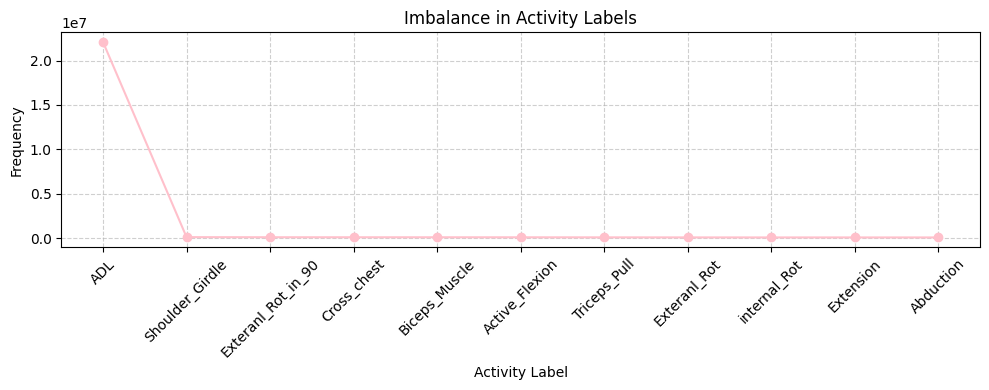

In [ ]:
#check imbalance of data

import matplotlib.pyplot as plt

counts = df['activity_label'].value_counts()
plt.figure(figsize=(8, 4))
plt.plot(counts.index, counts.values, marker='o', linestyle='-', color='pink')
plt.title('Imbalance in Activity Labels')
plt.xlabel('Activity Label')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# more information about data
# reduced_df.isnull().sum()
# reduced_df['activity_lable'].value_counts()
# reduced_df.info()


 **Balance of data**

---




In [10]:
ADL  = reduced_df[reduced_df['activity_label']=='ADL'].head(101911).copy()
Shoulder_Girdle   = reduced_df[reduced_df['activity_label']=='Shoulder_Girdle'].head(101911).copy()
Exteranl_Rot_in_90  = reduced_df[reduced_df[ 'activity_label']=='Exteranl_Rot_in_90'].head(90519).copy()
Cross_chest = reduced_df[reduced_df['activity_label']=='Cross_chest'].head(87743).copy()
Biceps_Muscle = reduced_df[reduced_df['activity_label']=='Biceps_Muscle'].head (86455).copy()
Active_Flexion = reduced_df[reduced_df['activity_label']=='Active_Flexion'].head(83855).copy()
Triceps_Pull   = reduced_df[reduced_df['activity_label']=='Triceps_Pull'].head(78103).copy()
Exteranl_Rot   = reduced_df[reduced_df['activity_label']=='Exteranl_Rot'].head(72019).copy()
internal_Rot   = reduced_df[reduced_df['activity_label']=='internal_Rot'].head(69043).copy()
Extension = reduced_df[reduced_df['activity_label']=='Extension'].head(68352).copy()
Abduction   = reduced_df[reduced_df['activity_label']=='Abduction'].head(68067).copy()

In [11]:
balanced_data = pd.concat([ADL, Shoulder_Girdle, Exteranl_Rot_in_90 , Cross_chest,Biceps_Muscle,
                                      Active_Flexion, Triceps_Pull ,Exteranl_Rot,internal_Rot,Extension,Abduction], ignore_index=True)
balanced_data.shape

(907978, 12)

<Axes: xlabel='activity_label'>

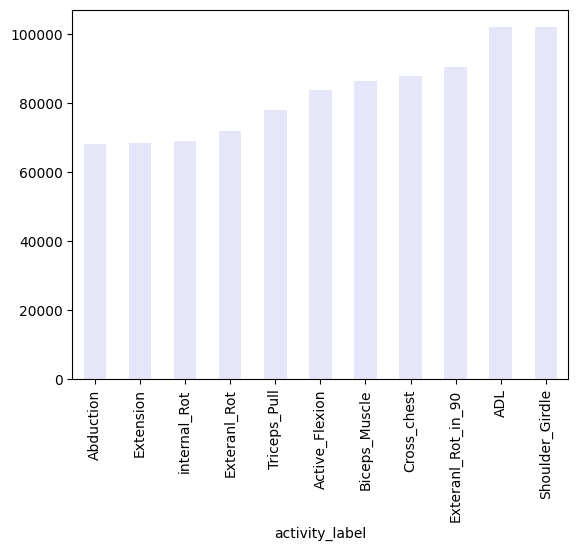

In [ ]:
balanced_data['activity_label'].value_counts().sort_values().plot(kind = 'bar', color = 'lavender')

 **Display the overlap between the exercises**

---



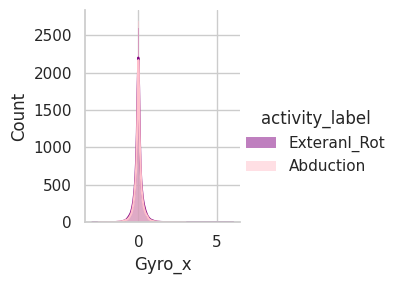

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


filtered_data = balanced_data[balanced_data['activity_label'].isin(['Abduction', 'Exteranl_Rot'])]

custom_palette = {
    'Abduction': 'pink',
    'Exteranl_Rot': 'purple'
}


sns.set(style="whitegrid")
g = sns.FacetGrid(filtered_data, hue='activity_label', palette=custom_palette)
g.map(sns.histplot, 'Gyro_x', kde=True).add_legend()
plt.show()


**Encodes categorical activity labels into numerical values**

---



In [12]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity_label'])
balanced_data.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,Gyro_x,Gyro_y,Gyro_z,HR,Shoulder,activity_label,label
0,-6.398438,-7.218750,-2.171875,119.0625,-39.40625,27.000000,-0.004890,-0.112610,-0.019745,86.0000,0.0,ADL,0
1,-6.394531,-7.398438,-2.158203,119.5000,-39.46875,28.000000,-0.167236,-0.063354,-0.020676,85.9375,0.0,ADL,0
2,-6.335938,-7.554688,-2.095703,119.7500,-39.53125,27.390625,-0.204590,-0.028122,-0.065125,85.9375,0.0,ADL,0
3,-6.316406,-7.609375,-2.085938,119.8125,-38.40625,27.578125,-0.114807,-0.061584,-0.116882,85.8750,0.0,ADL,0
4,-6.335938,-7.640625,-2.113281,119.2500,-38.90625,28.312500,0.111328,-0.066956,-0.154297,85.8125,0.0,ADL,0


In [ ]:
# Drop one column of HR
# balanced_data.drop(['HR'], axis = 1)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,Gyro_x,Gyro_y,Gyro_z,Shoulder,activity_label,label
0,-6.398438,-7.218750,-2.171875,119.062500,-39.40625,27.000000,-0.004890,-0.112610,-0.019745,0.0,ADL,0
1,-6.394531,-7.398438,-2.158203,119.500000,-39.46875,28.000000,-0.167236,-0.063354,-0.020676,0.0,ADL,0
2,-6.335938,-7.554688,-2.095703,119.750000,-39.53125,27.390625,-0.204590,-0.028122,-0.065125,0.0,ADL,0
3,-6.316406,-7.609375,-2.085938,119.812500,-38.40625,27.578125,-0.114807,-0.061584,-0.116882,0.0,ADL,0
4,-6.335938,-7.640625,-2.113281,119.250000,-38.90625,28.312500,0.111328,-0.066956,-0.154297,0.0,ADL,0
...,...,...,...,...,...,...,...,...,...,...,...,...
907973,-2.863281,-8.804688,-3.880859,15.765625,35.18750,8.507812,-0.047241,0.083618,0.001425,2.0,Abduction,1
907974,-2.503906,-9.054688,-3.958984,15.492188,34.78125,8.117188,-0.147583,-0.014122,-0.031311,2.0,Abduction,1
907975,-2.251953,-9.703125,-3.798828,14.945312,33.65625,7.777344,-0.168091,-0.108215,-0.065735,2.0,Abduction,1
907976,-2.080078,-9.765625,-3.460938,14.914062,34.00000,8.789062,0.033600,-0.176636,-0.079834,2.0,Abduction,1


In [13]:
x = balanced_data[['Acc_x','Acc_y','Acc_z','Mag_x','Mag_y','Mag_z','Gyro_x','Gyro_y','Gyro_z']]
y = balanced_data['label']

**Scales the sensor data to have zero mean and unit variance**

---



In [14]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
scaler =  StandardScaler()
x = scaler.fit_transform(x)
scaled_x = pd.DataFrame(data = x, columns = ['Acc_x','Acc_y','Acc_z','Mag_x','Mag_y','Mag_z',
                                             'Gyro_x','Gyro_y','Gyro_z'])
scaled_x['label'] = y.values
scaled_x

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,Gyro_x,Gyro_y,Gyro_z,label
0,-1.180664,-0.369873,-0.933105,4.554688,-2.554688,1.634766,-0.004265,-0.151367,-0.020004,0
1,-1.179688,-0.403809,-0.929688,4.574219,-2.556641,1.677734,-0.258789,-0.086060,-0.021057,0
2,-1.167969,-0.433350,-0.913574,4.582031,-2.558594,1.652344,-0.317383,-0.039368,-0.071838,0
3,-1.164062,-0.443604,-0.911133,4.585938,-2.511719,1.660156,-0.176514,-0.083740,-0.130981,0
4,-1.167969,-0.449463,-0.917969,4.562500,-2.533203,1.691406,0.177979,-0.090881,-0.173828,0
...,...,...,...,...,...,...,...,...,...,...
907973,-0.497314,-0.669434,-1.366211,0.501465,0.604980,0.840332,-0.070679,0.108765,0.004185,1
907974,-0.427734,-0.716797,-1.385742,0.490967,0.587891,0.823242,-0.227905,-0.020798,-0.033203,1
907975,-0.379150,-0.839355,-1.344727,0.469482,0.540039,0.808594,-0.260010,-0.145508,-0.072510,1
907976,-0.345703,-0.851074,-1.258789,0.468262,0.554688,0.852539,0.056061,-0.236206,-0.088623,1


**Segmentation of data**

---



This cell segments the sensor data into overlapping sliding windows of fixed size (100) with a step size of 10. For each window, it collects values from all 9 sensor axes and assigns the most frequent label (mode) in that window as its class, preparing the data for time-series model training.

In [15]:

import scipy.stats as stats
train_labels = []
X_train = []
window_size =100

step_size = 10

# creating overlaping windows of size window-size
for i in range(0, len(scaled_x) - window_size,step_size):
    accx=scaled_x['Acc_x'].values[i: i + window_size]
    accy=scaled_x['Acc_y'].values[i: i + window_size]
    accz=scaled_x['Acc_z'].values[i: i + window_size]
    magx=scaled_x['Mag_x'].values[i: i + window_size]
    magy=scaled_x['Mag_y'].values[i: i + window_size]
    magz=scaled_x['Mag_z'].values[i: i + window_size]
    gyrox=scaled_x['Gyro_x'].values[i: i + window_size]
    gyroy=scaled_x['Gyro_y'].values[i: i + window_size]
    gyroz=scaled_x['Gyro_z'].values[i: i + window_size]
    label=stats.mode(scaled_x['label'][i: i+ window_size])[0]

    train_labels.append(label)
    X_train.append([accx,accy,accz,magx,magy,magz,gyrox,gyroy,gyroz])



In [16]:
y_train = np.array(train_labels)
X_train = np.array( X_train)

**Split of data to train and test**

In [17]:
from sklearn.model_selection import train_test_split
X_train_train, X_train_test,y_train_train,y_train_test =train_test_split(X_train,y_train ,test_size = 0.10,random_state=0 )

In [ ]:
# y_train_test.shape
# X_train_train.shape

In [18]:
# One-hot encode the labels
from tensorflow.keras.utils import to_categorical
train_y = to_categorical(y_train_train, num_classes=11)
val_y = to_categorical(y_train_test, num_classes=11)

# **My transformer**

**Positional embeddings**


---


To help the model understand the temporal order of sensor data, this function encodes the position of each element in a sequence by appending sinusoidal positional embeddings to the input tensor.  This is crucial for identifying time-dependent patterns in motion data in the context of human activity detection, as this enhances the model's ability to distinguish between different physical activities.

In [19]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.initializers import TruncatedNormal

def add_positional_embeddings(inputs):
    units = inputs.shape[-1]
 # Define a function to compute the positional encodings
    def compute_positional_encoding(x):
        seq_len = tf.shape(x)[1]
        position = tf.range(seq_len, dtype=tf.float32)
        position = tf.expand_dims(position, axis=0)
        position = tf.expand_dims(position, axis=-1)

       # Compute angles for sine and cosine functions

        div_term = tf.pow(10000.0, tf.range(0, units, 2, dtype=tf.float32) / units)
        angle_rads = position / div_term

        # Apply sine to even indices, cosine to odd indices

        sines = tf.math.sin(angle_rads)
        cosines = tf.math.cos(angle_rads)

        # Concatenate sines and cosines to form the final positional encoding

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[:, :seq_len, :units]

        return x + pos_encoding

    # Apply the positional encoding
    x = layers.Lambda(compute_positional_encoding)(inputs)
    # Optional dense layer to project the output
    projection = layers.Dense(units, kernel_initializer=TruncatedNormal(stddev=0.02))
    output = projection(x)

    return output




**Residual block**


---


this cell implements a depthwise separable convolution layer followed by a residual block, which is efficient for extracting features from time-series data

In [20]:
import tensorflow as tf
from tensorflow.keras import layers

# Depthwise separable 1D convolution
def depthwise_separable_conv1d(inputs, filters, kernel_size):
    x = layers.DepthwiseConv1D(kernel_size,padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, 1)(x)
    return x

# Residual block
def residual_block(inputs, filters, kernel_size):
    x = depthwise_separable_conv1d(inputs, filters, kernel_size)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = depthwise_separable_conv1d(x, filters, kernel_size)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = depthwise_separable_conv1d(x, filters, kernel_size)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, inputs])  # Skip connection
    x = layers.ReLU()(x)
    return x

**Transformer encoder block**

---



This cell defines a transformer encoder block, consisting of multi-head attention, layer normalization, and a feed-forward neural network. It applies attention to the input, followed by a residual connection, and processes the result through a two-layer convolutional network for further feature extraction.

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
   # Normalization and Attention
   x = layers.LayerNormalization(epsilon=1e-6)(inputs)
   x = layers.MultiHeadAttention(
   key_dim=head_size, num_heads=num_heads, dropout=dropout
   )(x, x)
   x = layers.Dropout(dropout)(x)
   res = x + inputs

   # Feed Forward Part
   x = layers.LayerNormalization(epsilon=1e-6)(res)
   x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
   x = layers.Dropout(dropout)(x)
   x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
   return x + res

In [22]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_residual_blocks,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x= add_positional_embeddings(inputs)
    for _ in range (num_residual_blocks):
      x = residual_block(x, filters=100, kernel_size=3)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(11, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:

input_shape = X_train_train.shape[1:]

model = build_model(
    input_shape,
    head_size = 128,
    num_heads = 8,
    ff_dim = 64,
    num_residual_blocks=4,
    num_transformer_blocks =4,
    mlp_units = [256, 128],
    mlp_dropout = 0.1,
    dropout = 0.2,

)

model.compile(
    loss="categorical_crossentropy",
    metrics=['accuracy'],
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

history = model.fit(
    X_train_train,
    train_y,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/100
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 110s 45ms/step - accuracy: 0.6438 - loss: 0.8908 - val_accuracy: 0.8512 - val_loss: 0.3671
Epoch 2/100
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 85s 23ms/step - accuracy: 0.8523 - loss: 0.3679 - val_accuracy: 0.9180 - val_loss: 0.2200
Epoch 3/100
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.9037 - loss: 0.2494 - val_accuracy: 0.8901 - val_loss: 0.3169
Epoch 4/100
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9017 - loss: 0.2585 - val_accuracy: 0.9400 - val_loss: 0.1717
Epoch 5/100
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9357 - loss: 0.1702 - val_accuracy: 0.9416 - val_loss: 0.1607
Epoch 6/100
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9175 - loss: 0.2207 - val_accuracy: 0.9540 - val_loss: 0.1259
Epoch 7/100
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.9487 - loss: 0.1380 - val_accuracy: 0.9539 - val_loss: 0.1236
Epoch 8/100
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy:

**Performance of model**

---



In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the validation data
y_pred = model.predict(X_train_test)

# Convert the predicted labels to multilabel format using a threshold value
threshold = 0.5
y_pred_multilabel = (y_pred > threshold).astype(int)

# Compute the classification report
report = classification_report(val_y, y_pred_multilabel)

# Print the report
print(report)

284/284 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1029
           1       0.96      0.97      0.97       682
           2       1.00      1.00      1.00       859
           3       1.00      1.00      1.00       875
           4       1.00      1.00      1.00       889
           5       0.99      1.00      0.99       666
           6       0.98      0.97      0.98       745
           7       1.00      1.00      1.00       890
           8       1.00      1.00      1.00      1009
           9       1.00      1.00      1.00       798
          10       0.99      0.97      0.98       637

   micro avg       0.99      0.99      0.99      9079
   macro avg       0.99      0.99      0.99      9079
weighted avg       0.99      0.99      0.99      9079
 samples avg       0.99      0.99      0.99      9079



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the target variable
# y_train_test_encoded = to_categorical(y_train_test, num_classes=11)

# Evaluate the model with the encoded target variable
model.evaluate(X_train_test, y_train_test_encoded)

284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9936 - loss: 0.0240


[0.025996824726462364, 0.992400050163269]

In [ ]:
from sklearn import metrics
from keras.utils import to_categorical

# Make predictions on the validation data
y_pred = model.predict(X_train_test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(val_y, axis=1)

# Convert predicted class labels to one-hot encoding
y_pred_onehot = to_categorical(y_pred_classes, num_classes=val_y.shape[1])

# Calculate accuracy score
accuracy = metrics.accuracy_score(val_y, y_pred_onehot)

print("Accuracy: {}".format(accuracy))

284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Accuracy: 0.9924000440577156


In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

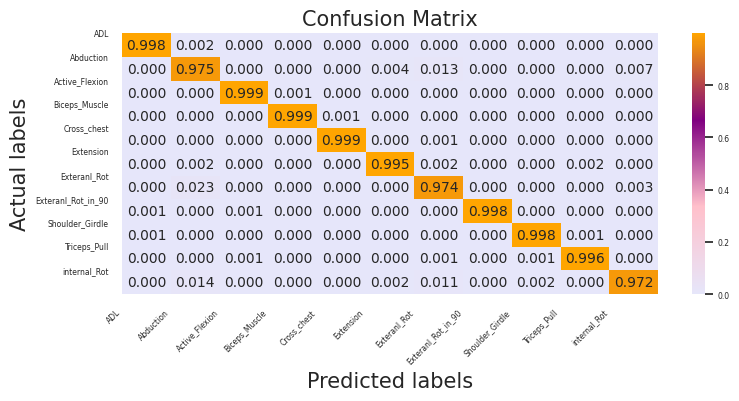

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormap
colors = ["lavender", "pink", "purple", "orange"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Generate confusion matrix
mat = confusion_matrix(y_true_classes, y_pred_classes)
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(mat, annot=True, annot_kws={"fontsize": 10}, cmap=cmap, fmt=".3f", ax=ax)
sns.set(font_scale=0.5)

label_font = {'size': '15'}
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('Actual labels', fontdict=label_font)

title_font = {'size': '15'}
ax.set_title('Confusion Matrix', fontdict=title_font)

tick_labels = ['ADL', 'Abduction', 'Active_Flexion', 'Biceps_Muscle',
               'Cross_chest', 'Extension', 'Exteranl_Rot', 'Exteranl_Rot_in_90',
               'Shoulder_Girdle', 'Triceps_Pull', 'internal_Rot']

ax.xaxis.set_ticks(np.arange(len(tick_labels)))
ax.xaxis.set_ticklabels(tick_labels, rotation=45, ha='right')

ax.yaxis.set_ticks(np.arange(len(tick_labels)))
ax.yaxis.set_ticklabels(tick_labels, rotation=0, ha='right')

plt.tight_layout()
plt.show()


In [ ]:
def plot_learningCurve(history):
    epochs = len(history.history['accuracy'])
    epoch_range = range(1, epochs+1)

    # Plot training & validation accuracy values
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
# Call the function with the history object and number of epochs


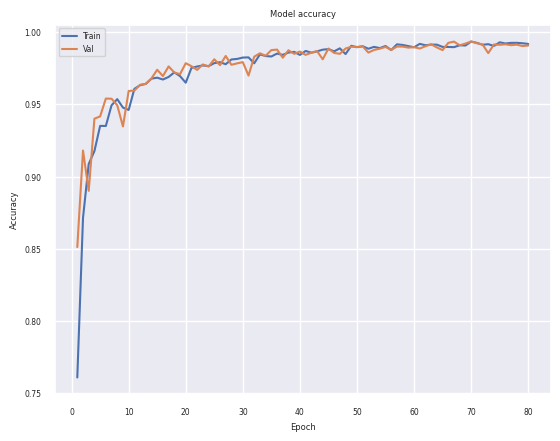

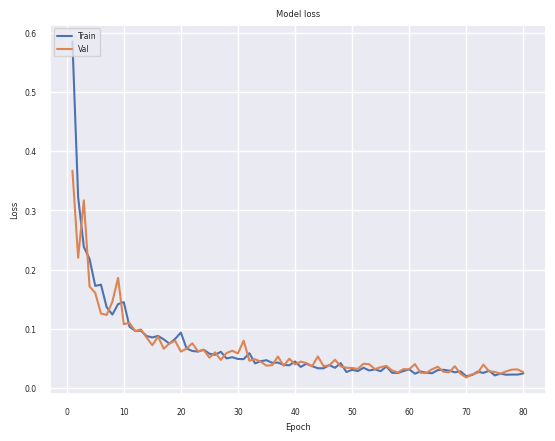

In [ ]:
plot_learningCurve (history)

# **Distillation Knowledge**

---

Construct Distiller class

In [23]:
import keras
from keras import layers
from keras import ops
import numpy as np

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the input shape
input_shape = X_train_train.shape[1:]

# Define the teacher model
teacher_model = build_model(
    input_shape,
    head_size=128,
    num_heads=8,
    ff_dim=64,
    num_residual_blocks=4,
    num_transformer_blocks=4,
    mlp_units=[256, 128],
    dropout=0.2,
    mlp_dropout=0.1,
)



# Define the student model
student_model= build_model(
    input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=16,
    num_residual_blocks=2,
    num_transformer_blocks=2,
    mlp_units=[32, 16],
    dropout=0.2,
    mlp_dropout=0.1,
)



# **Train Teacher**

In [25]:
# Compile the teacher model

teacher_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["sparse_categorical_accuracy"],
)
callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]
history_t =teacher_model.fit(
    X_train_train,
    y_train_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
  )

Epoch 1/50
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 116s 28ms/step - loss: 0.8359 - sparse_categorical_accuracy: 0.6608 - val_loss: 0.3899 - val_sparse_categorical_accuracy: 0.8440
Epoch 2/50
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 94s 18ms/step - loss: 0.4170 - sparse_categorical_accuracy: 0.8330 - val_loss: 0.2896 - val_sparse_categorical_accuracy: 0.8847
Epoch 3/50
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 0.2906 - sparse_categorical_accuracy: 0.8876 - val_loss: 0.3318 - val_sparse_categorical_accuracy: 0.8894
Epoch 4/50
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - loss: 0.2406 - sparse_categorical_accuracy: 0.9083 - val_loss: 0.2006 - val_sparse_categorical_accuracy: 0.9274
Epoch 5/50
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.2009 - sparse_categorical_accuracy: 0.9239 - val_loss: 0.1736 - val_sparse_categorical_accuracy: 0.9326
Epoch 6/50
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 0.1999 - sparse_categorical_accuracy: 0.9269 - val_loss: 0.1631 - val_sparse_categori

In [26]:
teacher_model.evaluate(X_train_test, y_train_test)

284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0381 - sparse_categorical_accuracy: 0.9865


[0.040962979197502136, 0.9871131181716919]

# **Distill teacher to student**

---

This code performs knowledge distillation where a smaller student model learns from a larger teacher model.


In [31]:
# Initialize and compile distiller
distiller = Distiller(student=student_model, teacher=teacher_model)
callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

distiller.fit( X_train_train, y_train_train, epochs=3,callbacks=callbacks)
distiller.evaluate(X_train_test, y_train_test)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


2554/2554 ━━━━━━━━━━━━━━━━━━━━ 74s 17ms/step - sparse_categorical_accuracy: 0.6282 - distillation_loss: 0.0150 - loss: 0.0909 - student_loss: 0.6769
Epoch 2/3
   8/2554 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - sparse_categorical_accuracy: 0.7707 - distillation_loss: 0.0125 - loss: 0.0909 - student_loss: 0.5258

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,distillation_loss,loss,student_loss
  current = self.get_monitor_value(logs)


2554/2554 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - sparse_categorical_accuracy: 0.8062 - distillation_loss: 0.0101 - loss: 0.0909 - student_loss: 0.4348
Epoch 3/3
2554/2554 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - sparse_categorical_accuracy: 0.8513 - distillation_loss: 0.0081 - loss: 0.0909 - student_loss: 0.3478
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - sparse_categorical_accuracy: 0.9051 - loss: 0.0909 - student_loss: 0.2451


[<tf.Tensor: shape=(), dtype=float32, numpy=0.09090936928987503>,
 {'sparse_categorical_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.9056063294410706>},
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11130685359239578>]

# **Train student**

---



In [32]:

student_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]
history_s =student_model.fit(
    X_train_train,
    y_train_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,

    )
# student_model.fit( X_train_train, y_train_train, epochs=10)
student_model.evaluate(X_train_test, y_train_test)

Epoch 1/50
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - loss: 0.2962 - sparse_categorical_accuracy: 0.8847 - val_loss: 0.2286 - val_sparse_categorical_accuracy: 0.9103
Epoch 2/50
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.2574 - sparse_categorical_accuracy: 0.9006 - val_loss: 0.1676 - val_sparse_categorical_accuracy: 0.9378
Epoch 3/50
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.2131 - sparse_categorical_accuracy: 0.9207 - val_loss: 0.1506 - val_sparse_categorical_accuracy: 0.9417
Epoch 4/50
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.1915 - sparse_categorical_accuracy: 0.9326 - val_loss: 0.1610 - val_sparse_categorical_accuracy: 0.9387
Epoch 5/50
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.1747 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.1268 - val_sparse_categorical_accuracy: 0.9556
Epoch 6/50
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.1632 - sparse_categorical_accuracy: 0.9421 - val_loss: 0.1364 - val_sparse_categorical_ac

[0.055397845804691315, 0.9829276204109192]

# **Evaluation**

In [ ]:
# student_model.summary()

In [ ]:
# teacher_model.summary()

In [33]:
def plot_learningCurve(history):
    epochs = len(history.history['sparse_categorical_accuracy'])
    epoch_range = range(1, epochs+1)

    # Plot training & validation accuracy values
    # Changed 'accuracy' to 'sparse_categorical_accuracy'
    plt.plot(epoch_range, history.history['sparse_categorical_accuracy'])
    # Changed 'val_accuracy' to 'val_sparse_categorical_accuracy'
    plt.plot(epoch_range, history.history['val_sparse_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
# Call the function with the history object and number of epochs

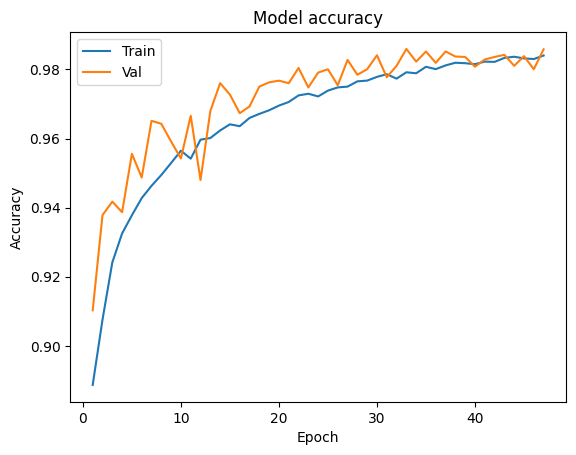

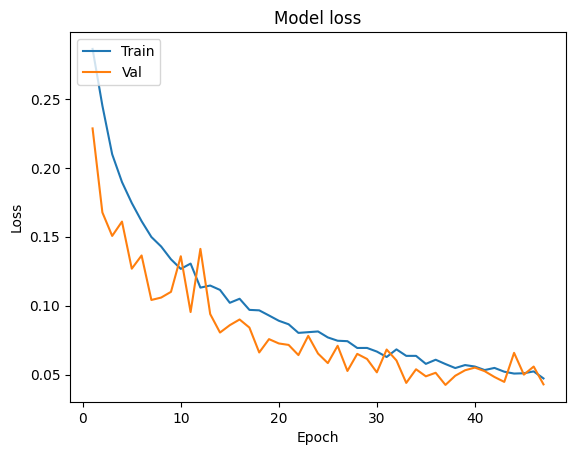

In [34]:
plot_learningCurve (history_s)

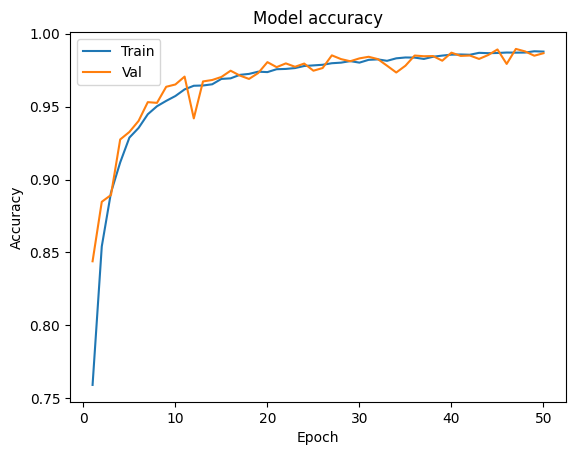

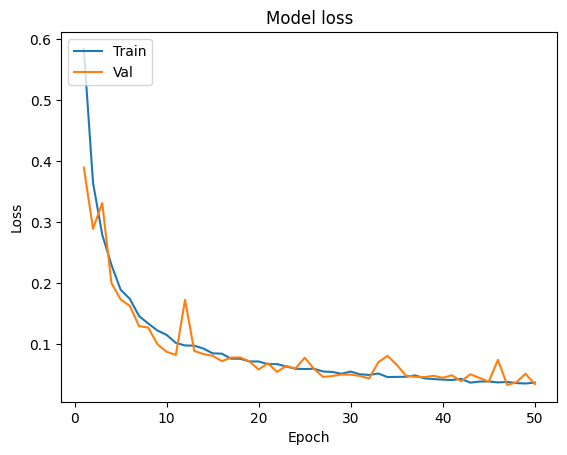

In [35]:
plot_learningCurve (history_t)

In [ ]:
# from sklearn.metrics import classification_report

# # Make predictions on the validation data
# y_pred = teacher_model.predict(X_train_test)

# # Convert the predicted labels to multilabel format using a threshold value
# threshold = 0.5
# y_pred_multilabel = (y_pred > threshold).astype(int)

# # Compute the classification report
# report = classification_report(val_y, y_pred_multilabel)

# # Print the report
# print(report)

284/284 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1029
           1       0.97      0.92      0.94       682
           2       1.00      1.00      1.00       859
           3       1.00      1.00      1.00       875
           4       1.00      1.00      1.00       889
           5       0.97      0.99      0.98       666
           6       0.94      0.95      0.95       745
           7       1.00      1.00      1.00       890
           8       1.00      1.00      1.00      1009
           9       1.00      0.99      0.99       798
          10       0.96      0.95      0.95       637

   micro avg       0.99      0.98      0.98      9079
   macro avg       0.98      0.98      0.98      9079
weighted avg       0.99      0.98      0.98      9079
 samples avg       0.98      0.98      0.98      9079



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# from sklearn.metrics import classification_report

# # Make predictions on the validation data
# y_pred = student_model.predict(X_train_test)

# # Convert the predicted labels to multilabel format using a threshold value
# threshold = 0.5
# y_pred_multilabel = (y_pred > threshold).astype(int)

# # Compute the classification report
# report = classification_report(val_y, y_pred_multilabel)

# # Print the report
# print(report)

284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1029
           1       0.94      0.94      0.94       682
           2       1.00      1.00      1.00       859
           3       1.00      1.00      1.00       875
           4       1.00      1.00      1.00       889
           5       0.99      0.98      0.98       666
           6       0.96      0.92      0.94       745
           7       1.00      1.00      1.00       890
           8       1.00      1.00      1.00      1009
           9       0.99      0.99      0.99       798
          10       0.92      0.94      0.93       637

   micro avg       0.98      0.98      0.98      9079
   macro avg       0.98      0.98      0.98      9079
weighted avg       0.98      0.98      0.98      9079
 samples avg       0.98      0.98      0.98      9079



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **References**

---
https://keras.io/examples/vision/knowledge_distillation/

https://google.com
